# Introduction 

In this notebook, we will implement [*Latent Credible Analysis*](https://research.fb.com/publications/latent-credibility-analysis/) models. These are latent probablistic models that use hidden (latent) variables to represents the unknown data source reliabilities and underlying truth values. 

We implement only simpleLCA for now as extension to other models are relatively straight forward.



# SimpleLCA

Here is the plate model of simpleLCA. 

![simpleLCA](./gfx/simpleLCA.png)

### Data 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os.path as op
import numpy as np
import seaborn as sns
import pyro

import sys
sys.path.insert(0, '../')

from spectrum.preprocessing import encoders
from spectrum.judge import lca, utils
from spectrum import evaluator

In [3]:
DATA_DIR = '../data'
DATA_SET = 'population'

In [4]:
truths = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'truths.csv'))
claims = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'claims.csv'))

In [5]:
truths.shape, claims.shape

((293, 3), (1035, 5))

We decide to model city population as discrete value. Moreover we consider the hidden truth value is only from the set of available assertions. Thus we need to label encode `value` of claims data frame.

### Data Preprocessing 

We need to label encode values of objects in order to feed them to our simpleLCA model

In [6]:
claims_enc, le_dict = encoders.transform(claims)

In [7]:
claims_enc

,object,SourceID,value,object_id,source_id
0,pepin_wisconsin_Population2000,5512121: CapitalBot,0,197,555
1,pepin_wisconsin_Population2000,1960810: Nyttend,1,197,393
2,tupelo_mississippi_Population2000,104574: ArkansasTraveler,0,266,294
3,tupelo_mississippi_Population2000,0 (74.227.33.192),1,266,252
4,tupelo_mississippi_Population2000,0 (72.147.247.16),2,266,231
...,...,...,...,...,...
1030,onslow_iowa_Population2000,0 (216.159.16.2),1,188,86
1031,onslow_iowa_Population2000,1960810: Nyttend,0,188,393
1032,onslow_iowa_Population2000,5967546: Tom hanks rox,2,188,574
1033,raleigh_northcarolina_Population2000,5512121: CapitalBot,0,208,555


### Model

# Inference 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

In [9]:
# svi = lca.bvi(lca.lca_model, lca.lca_guide, claims_enc, epochs=20, num_samples=1, learning_rate=1e-5)
svi = lca.bvi(lca.lca_model, lca.lca_guide, claims_enc, learning_rate=0.1, num_samples=1)

In [10]:
losses = []

In [11]:
losses.extend(lca.fit(svi, claims_enc, epochs=5))

current loss - 9581.3154296875
current loss - 9330.923828125
current loss - 9390.5263671875
current loss - 9604.5693359375
current loss - 9418.4306640625


/Users/totucuong/miniconda3/envs/spectrum-dev/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


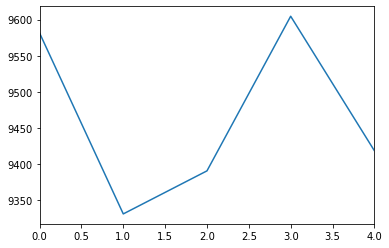

In [12]:
sns.tsplot(losses)

# Evaluation 

In [13]:
discovered_truths = lca.discover_truths(posteriors=pyro.get_param_store())

We need to inverse transform the discovered truth value of each object into their original space.

In [14]:
discovered_truths['value'] = discovered_truths.apply(lambda x: le_dict[x['object_id']].inverse_transform([x['value']])[0], axis=1)

In [15]:
evaluator.accuracy(truths, discovered_truths)

0.47440273037542663

The result is bad. This is expected if we look at the plot of loss values during training. They did not converge! The following can be reasons:
    1. Since SVI estimate gradients at each training step by performing sampling of `guide()`. The default number of is 1. We may increase the estimation accuracy by increasing the number of training.
    2. Our `guide()` model is just not good enough or `model()

# Appendix